In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import logging
import numpy as np 
import pandas as pd
logging.basicConfig(level=logging.ERROR)
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [32]:
!pip install transformers
!pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [4]:
import json
with open("/kaggle/input/quantemp-claims/test_claims_quantemp.json") as f:
  test_data = json.load(f)

print(len(test_data))
test_data[-1]

2495


{'crawled_date': '2022-09-24',
 'country_of_origin': 'india',
 'label': 'False',
 'url': 'https://www.indiatoday.in/fact-check/story/fact-check-woman-seen-with-rahul-gandhi-is-not-amulya-leona-student-who-chanted-pak-zindabad-2004338-2022-09-24',
 'lang': 'en',
 'claim': "During the Bharat Jodo Yatra, Rahul Gandhi was seen with Amulya Leona Noronha, the woman who was arrested for saying 'Pakistan Zindabad' during an anti-CAA rally in 2020.",
 'doc': 'AFWA\'s investigation found that the woman seen in the viral photo is not Amulya Leona Noronha. Rahul Gandhi and members of the Congress party, as part of the Bharat Jodo Yatra, have met locals and leaders alike as they move from city to city on foot. Of the many, many photos from the road, one shows Gandhi posing with a young woman. The Congress leader was giving her a side-hug. This photo has been widely shared with some questionable claims. They alleged that the woman in the photo is Amulya Leona Noronha, a student who chanted “Pakistan

In [18]:
from sklearn.preprocessing import LabelEncoder
import numpy as np 
import re
LE = LabelEncoder()
test_labels = [fact["label"] for fact in test_data]
print(test_labels[:5])
test_taxonomy_labels = [fact["taxonomy_label"] for fact in test_data]
test_labels_final = LE.fit_transform(test_labels)
print(test_labels_final[:5])
print(np.unique(test_labels_final))

['Conflicting', 'True', 'False', 'False', 'True']
[0 2 1 1 2]
[0 1 2]


In [19]:
import csv 
with open('/kaggle/input/quantemp/top_20_test.csv', 'r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    test_features_final = [row for row in reader]
    
print(len(test_features_final))
print(len(test_data))

2495
2495


In [36]:
from transformers import AutoTokenizer,AutoModel

def create_tokenizer(model_name):
    # Load the tokenizer.
    print('Loading tokenizer...')
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
    return tokenizer

In [37]:
def encode(tokenizer, test_features_final):
    test_input_ids = []
    test_attention_masks = []

    for index, evidences in enumerate(test_features_final):
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        text = "[Evidences]:"
        claim = test_data[index]['claim']
        for evidence in evidences:
          text += evidence + ". "
        result = "[Claim]:" + claim + text
        encoded_dict = tokenizer.encode_plus(
                            result,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 256,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            truncation=True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.
        test_input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        test_attention_masks.append(encoded_dict['attention_mask'])
    # Convert the lists into tensors.
    test_input_ids = torch.cat(test_input_ids, dim=0)
    test_attention_masks = torch.cat(test_attention_masks, dim=0)

    # Print sentence 0, now as a list of IDs.
    # print('Original: ', train_features_final[0])
    # print('Token IDs:', input_ids[0])
    return test_input_ids , test_attention_masks


In [38]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

def create_dataset(test_input_ids, test_attention_masks, test_labels_final):
    test_labels_final = torch.tensor(test_labels_final)
    num_classes = len(list(set(test_labels)))
    list(set(test_labels))
    test_dataset = TensorDataset(test_input_ids, test_attention_masks,test_labels_final)
    return test_dataset
    
    
def create_dataloader(test_dataset):
    batch_size = 16
    test_dataloader = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset),
                batch_size = batch_size
    )
    return test_dataloader

In [39]:
from torch import nn
class MultiClassClassifier(nn.Module):
    def __init__(self, bert_model_path, labels_count,isGoogle, hidden_dim=768, mlp_dim=500, extras_dim=100, dropout=0.1, freeze_bert=False):
        super().__init__()
        self.isGoogle = isGoogle 

        self.model = AutoModel.from_pretrained(bert_model_path,output_hidden_states=True,output_attentions=True)
        self.dropout = nn.Dropout(dropout)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, mlp_dim),
            nn.ReLU(),
            # nn.Linear(mlp_dim, mlp_dim),
            # # nn.ReLU(),
            # # nn.Linear(mlp_dim, mlp_dim),
            # nn.ReLU(),
            nn.Linear(mlp_dim, labels_count)
        )
        # self.softmax = nn.LogSoftmax(dim=1)
        if freeze_bert:
            print("Freezing layers")
            for param in self.model.parameters():
                param.requires_grad = False

    def forward(self, tokens, masks):
        if not self.isGoogle:
            output = self.model(tokens, attention_mask=masks) # Roberta, BART, Siloed/Deberta 
        else:
            output = self.model(   #flan and t5
            input_ids=tokens,
            attention_mask=masks,
            decoder_input_ids=tokens
            )
            
        last_hidden_state = output.last_hidden_state
        pooled_output = last_hidden_state.mean(dim=1)
        dropout_output = self.dropout(pooled_output)
        # concat_output = torch.cat((dropout_output, topic_emb), dim=1)
        # concat_output = self.dropout(concat_output)
        mlp_output = self.mlp(dropout_output)
        # proba = self.sigmoid(mlp_output)
        # proba = self.softmax(mlp_output)

        return mlp_output

In [40]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
def create_model(model_name,hidden_neurons, directory, isGoogle):
    num_classes = len(list(set(test_labels)))
    #flan and T5: 512 hidden_dim 
    #Roberta: 1024 hidden_dim 
    #Bart: 1024 hidden_dim
    #Deberta: 768 hidden_dim
    #Roberta_math: 768 hidden_dim
    # Loads BertForSequenceClassification, the pretrained BERT model with a single
    model = MultiClassClassifier(model_name,num_classes,isGoogle, hidden_neurons,768,140,dropout=0.1,freeze_bert=False)

    model.load_state_dict(torch.load(f"{directory}"))

    # # Tell pytorch to run this model on the GPU.
    model.cuda()
    return model 

In [41]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


loss_func = nn.CrossEntropyLoss()


In [42]:
from collections import defaultdict

def store_in_df_per_batch(model_name, logits, labels, df):
    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for i in range(len(pred_flat)):
        df.append((model_name, pred_flat[i] ,labels_flat[i])) 
        
    return df

def accuracy_per_category(logits, labels, categories, category_correct, category_total):
    """
    Calculate accuracy for each category.
    """
    
    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = labels.flatten()
    categories_flat = {0 : "Conflicting" , 1 : "False" , 2 : "True"} 
    for i in range(len(labels_flat)):
        category_total[categories_flat[labels_flat[i]]] += 1
        if pred_flat[i] == labels_flat[i]:
            category_correct[categories_flat[labels_flat[i]]] += 1
    
    return category_correct , category_total 

In [51]:
def convert_to_df(df):
    df = pd.DataFrame(df, columns = ['model' , 'prediction' , 'actual']) 
    df['taxonomy'] = test_taxonomy_labels
    return df

def run_model_on_test(model_name, hidden_neurons,test_labels_final, directory, isGoogle):
    tokenizer = create_tokenizer(model_name) 
    test_input_ids, test_attention_masks = encode(tokenizer, test_features_final) 
    model = create_model(model_name,hidden_neurons, directory, isGoogle)
    test_dataset = create_dataset(test_input_ids, test_attention_masks, test_labels_final)
    test_dataloader = create_dataloader(test_dataset)
    
    # Evaluate data for one epoch
    total_eval_loss = 0 
    t0 = time.time()
    total_eval_accuracy = 0
    df = [] 
    for batch in test_dataloader:
        category_correct = {'Conflicting' : 0 , "True" : 0 , "False": 0} 
        category_total = {'Conflicting' : 0 , "True" : 0 , "False": 0} 
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)

        b_input_mask = batch[1].to(device)
        # b_poincare = batch[2].to(device)
        # b_difficulty = batch[3].to(device)
        b_labels = batch[2].to(device)
        #b_categories = batch[3].to(device)
        # skill_labels = batch[3].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
          logits = model(b_input_ids,b_input_mask)

            # Accumulate the validation loss.
        loss = loss_func(logits, b_labels)
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        category_ids = None
        ### store in df
        df = store_in_df_per_batch(model_name, logits, label_ids,df) 
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        category_correct, category_total = accuracy_per_category(logits, label_ids, category_ids,category_correct, category_total)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    print(f"{model_name} Accuracy: {avg_val_accuracy:.2f}")

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(test_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  test Loss: {0:.2f}".format(avg_val_loss))
    print("  test took: {:}".format(validation_time))
    category_accuracy = {cat: category_correct[cat] / category_total[cat] for cat in category_total}

    return convert_to_df(df) 

In [52]:
import warnings
warnings.filterwarnings("ignore")
df_roberta = run_model_on_test('roberta-large-mnli' ,1024,test_labels_final,'/kaggle/input/model-weights/model_weights/model_weights_roberta',False) 
df_BART = run_model_on_test('facebook/bart-large-mnli' ,1024,test_labels_final,'/kaggle/input/model-weights/model_weights/model_weights_BART',False) 
df_deberta = run_model_on_test('sileod/deberta-v3-base-tasksource-nli' ,768,test_labels_final,'/kaggle/input/model-weights/model_weights/model_weights_deberta',False) 
df_flan = run_model_on_test( 'google/flan-t5-small' ,512,test_labels_final,'/kaggle/input/model-weights/model_weights/model_weights_flan',True) 
df_t5 = run_model_on_test( 'google-t5/t5-small' ,512,test_labels_final,'/kaggle/input/model-weights/model_weights/model_weights_T5',True) 
df_roberta_math = run_model_on_test('AnReu/math_pretrained_roberta' ,768,test_labels_final,'/kaggle/input/model-weights/model_weights/model_weights_roberta_math',False) 

Loading tokenizer...
roberta-large-mnli Accuracy: 0.57
  test Loss: 0.98
  test took: 0:01:55
Loading tokenizer...
facebook/bart-large-mnli Accuracy: 0.65
  test Loss: 0.83
  test took: 0:02:18
Loading tokenizer...
sileod/deberta-v3-base-tasksource-nli Accuracy: 0.64
  test Loss: 0.83
  test took: 0:00:50
Loading tokenizer...
google/flan-t5-small Accuracy: 0.61
  test Loss: 0.85
  test took: 0:00:29
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

google-t5/t5-small Accuracy: 0.62
  test Loss: 0.85
  test took: 0:00:24
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/9.95k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/812 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/500M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at AnReu/math_pretrained_roberta and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AnReu/math_pretrained_roberta Accuracy: 0.63
  test Loss: 0.82
  test took: 0:00:37


In [54]:
df = pd.concat([df_roberta ,df_t5, df_BART, df_deberta, df_flan, df_roberta_math] , ignore_index=True) 
df.to_csv('model_predictions.csv', index=False)

In [55]:
def calculate_accuracy(df, model_name):
    subset = df[df['model'] == model_name]
    correct_predictions = subset[subset['prediction'] == subset['actual']].shape[0]
    total_predictions = subset.shape[0]
    accuracy = correct_predictions / total_predictions
    return round(accuracy, 2)


def calculate_accuracy_taxonomy(group):
    correct_predictions = (group['prediction'] == group['actual']).sum()
    total_predictions = group.shape[0]
    return correct_predictions / total_predictions

In [56]:
models = df['model'].unique()
accuracy_total = {model: calculate_accuracy(df, model) for model in models}
print(accuracy_total)

{'roberta-large-mnli': 0.57, 'google-t5/t5-small': 0.62, 'facebook/bart-large-mnli': 0.65, 'sileod/deberta-v3-base-tasksource-nli': 0.64, 'google/flan-t5-small': 0.61, 'AnReu/math_pretrained_roberta': 0.63}


In [57]:
accuracy_df_taxonomy = df.groupby(['model', 'taxonomy']).apply(calculate_accuracy_taxonomy).reset_index()
accuracy_df_taxonomy.columns = ['model', 'taxonomy_label', 'accuracy']

In [60]:
accuracy_df_taxonomy = accuracy_df_taxonomy.drop([4, 9, 14,19, 24, 29]) 
accuracy_df_taxonomy = accuracy_df_taxonomy.reset_index(drop=True)
#accuracy_df_taxonomy

Index(['model', 'prediction', 'actual', 'taxonomy'], dtype='object')


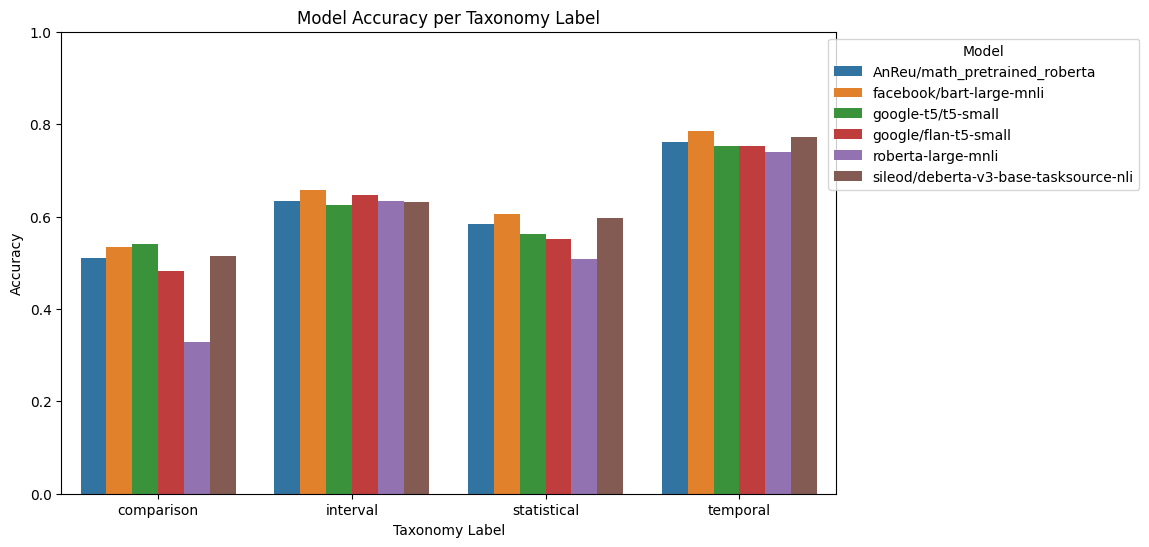

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
print(df.columns)
# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='taxonomy_label', y='accuracy', hue='model', data=accuracy_df_taxonomy)

# Add labels and title
plt.xlabel('Taxonomy Label')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Taxonomy Label')
plt.ylim(0, 1)  # Set the y-axis limit to range from 0 to 1
plt.legend(title='Model', loc='upper right', bbox_to_anchor=(1.4, 1))

plt.show() 

(0.0, 1.0)

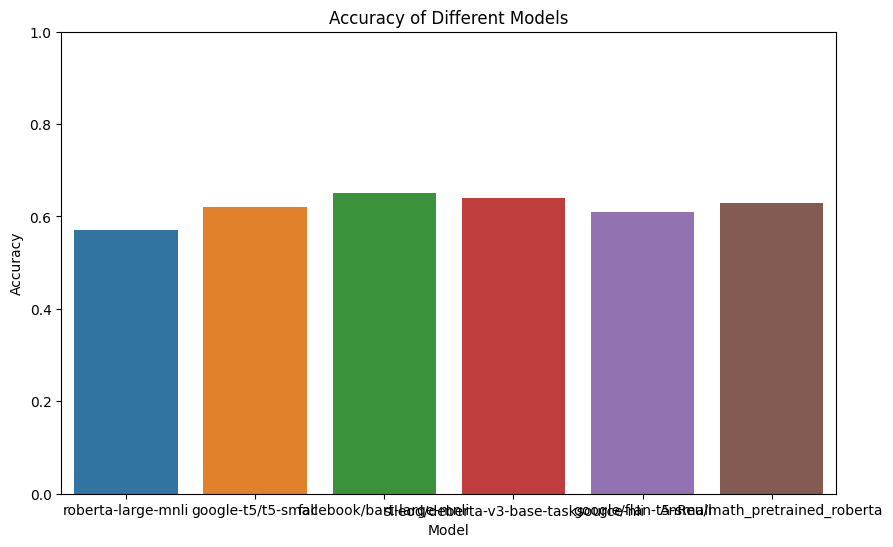

In [62]:
# Convert the dictionary to a DataFrame
accuracy_df = pd.DataFrame(list(accuracy_total.items()), columns=['Model', 'Accuracy'])
#models = ["Roberta" , "T5" , "BART" , "Deberta" ,"FLAN" , "MathRoberta" ]
accuracy_df['model_names_short'] = models
# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='model_names_short', y='Accuracy', data=accuracy_df)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to range from 0 to 1

In [2]:
###################################### Qualitative analysis of claims 

df = pd.read_csv('/kaggle/input/model-predictions/model_predictions_top_20.csv') 
print(len(df)) 

14970


In [5]:
indices = [] 
for i in range(6):
    indices = indices + [j for j in range(len(test_data))] 

In [6]:
df['claim index'] = indices 
df = df[df['taxonomy'] != 'temporal   ']
print(df['taxonomy'].unique())
print( df['taxonomy'].value_counts())
df.head()


['statistical' 'temporal' 'comparison' 'interval']
taxonomy
statistical    7260
temporal       4086
interval       2082
comparison     1530
Name: count, dtype: int64


,model,prediction,actual,taxonomy,claim index
0,roberta-large-mnli,1,0,statistical,0
1,roberta-large-mnli,1,2,statistical,1
2,roberta-large-mnli,1,1,temporal,2
3,roberta-large-mnli,1,1,statistical,3
4,roberta-large-mnli,1,2,temporal,4


In [23]:
# Assuming you have a DataFrame df
# Create a boolean column indicating if the prediction is wrong
df['is_wrong'] = df['prediction'] != df['actual']

# Pivot the DataFrame to get a wide format where each row is a claim, and columns are models' correctness
pivot_df = df.pivot_table(index=['claim index', 'taxonomy'], columns='model', values='is_wrong', aggfunc='first')
# # Filter for claims where all models made a wrong prediction
all_wrong = pivot_df.apply(lambda row: all(row), axis=1)
wrong_predictions_df = pivot_df[all_wrong].reset_index()
# Now group by taxonomy and get a random subset from each group
random_subset = wrong_predictions_df.groupby('taxonomy').apply(lambda x: x.sample(n=5,replace=True, random_state=42)).reset_index(drop=True)

# Print the result
(random_subset)

/tmp/ipykernel_33/3178485954.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_subset = wrong_predictions_df.groupby('taxonomy').apply(lambda x: x.sample(n=5,replace=True, random_state=42)).reset_index(drop=True)


model,claim index,taxonomy,AnReu/math_pretrained_roberta,facebook/bart-large-mnli,google-t5/t5-small,google/flan-t5-small,roberta-large-mnli,sileod/deberta-v3-base-tasksource-nli
0,2010,comparison,True,True,True,True,True,True
1,1124,comparison,True,True,True,True,True,True
2,789,comparison,True,True,True,True,True,True
3,1459,comparison,True,True,True,True,True,True
4,1392,comparison,True,True,True,True,True,True
5,1863,interval,True,True,True,True,True,True
6,1263,interval,True,True,True,True,True,True
7,636,interval,True,True,True,True,True,True
8,2058,interval,True,True,True,True,True,True
9,435,interval,True,True,True,True,True,True


In [40]:
#['Conflicting', 'True', 'False']
#[0 2 1]
arr = [] 
i = 0 
pf = pd.read_csv('/kaggle/input/model-predictions/model_predictions_top_20.csv') 
for index, row in random_subset.iterrows():
    
    claim_index = row['claim index'] 
    taxonomy = row['taxonomy'] 
    claim = test_data[claim_index]['claim'] 
    #arr.append((claim , taxonomy,test_features_final[claim_index])) 
    evidences = test_features_final[claim_index]
    temp =[] 
    s = claim_index 
    for i in range(6):
        temp.append(df.iloc[s]['prediction']) 
    print(f"claim: {claim} \n taxonomy : {taxonomy} actual label: {test_labels[claim_index]}  predictions:{temp}")
    print(evidences)
#     if i == 2:
#         break 
#     i += 1
#     break 
    break 
    
new_df = pd.DataFrame(arr, columns=['claim', 'taxonomy', 'evidence'])
    

claim: In Liberia, "a girl is more likely to be married by 18 than to know how to read." 
 taxonomy : comparison actual label: Conflicting  predictions:[1, 1, 1, 1, 1, 1]
['e-mail: lcs.ga@state.co.us. m e m o r a n d u m age of sexual consent is most commonly defined as the minimum age at which an individual.', 'age distribution of study population. age (years). female. n(%). male. n population in ambala district. 18654 | p a g e is probably due to the', '... their antecedents|matthew henry habershon, y e r v o y (ipilimumab): treats ... pre-colonial burmese state (occasional paper series)|michael aung-thwin ...', 'de e cruz  2016  cit 14 fois  first, i address how undocumented young immigrants have politicized a considerable sector of u.s. youth through their influence on the migration debate, a ...', 'jul 27, 2018  (iii). c o n t e n t s. opening statements. page. hatch, hon. orrin g., a u.s. senator from utah, chairman, committee on. finance .', '... year images 2023, ciclos porque 

In [17]:
new_df

,claim,taxonomy,evidence
0,"In Liberia, ""a girl is more likely to be marri...",comparison,[e-mail: lcs.ga@state.co.us. m e m o r a n d u...
1,"Muslim nations did not ""call out"" the people w...",comparison,"[they are also told that, if they. d o n 't ke..."
2,"The 60+ Oyster card counts as voter ID, but th...",comparison,[s t a t e of a l a s k a. division of electio...
3,"""It is wrong for the average federal worker to...",comparison,[... washington post accuses trump of a crime ...
4,"""Did you know Wisconsin's AFSCME union has los...",comparison,[by n wexler 2022 cited by 1 i show that wa...
5,“Central Park actually used to be a town calle...,interval,"[... bongbong's native delicacies, cereja bene..."
6,Taiwan has claimed to have shot down a Chinese...,interval,[by e staunton 1999 cited by 24 night-time ...
7,Twitter owner Elon Musk tweeted that Democrats...,interval,[alone has pledged about $45 billion in arms a...
8,A photograph shows a pagoda flower that only b...,interval,"[... picture, provinces of ireland meath, perf..."
9,Al Gore predicted that Earth’s “ice caps” woul...,interval,[de t yamanouchi 2011 cit 90 fois global su...


/tmp/ipykernel_33/763642331.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_scores_macro = pf.groupby('model').apply(lambda x: f1_score(x['actual'], x['prediction'], average='macro')).reset_index()
/tmp/ipykernel_33/763642331.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_scores_weighted = pf.groupby('model').apply(lambda x: f1_score(x['actual'], x['prediction'], average='weighted')).reset_i

0            AnReu/math_pretrained_roberta
1                 facebook/bart-large-mnli
2                       google-t5/t5-small
3                     google/flan-t5-small
4                       roberta-large-mnli
5    sileod/deberta-v3-base-tasksource-nli
Name: model, dtype: object
                                   model  f1_score_macro  f1_score_weighted
0          AnReu/math_pretrained_roberta        0.549710           0.630418
1               facebook/bart-large-mnli        0.557186           0.641010
2                     google-t5/t5-small        0.499431           0.599547
3                   google/flan-t5-small        0.504206           0.599624
4                     roberta-large-mnli        0.242130           0.414290
5  sileod/deberta-v3-base-tasksource-nli        0.560868           0.638622


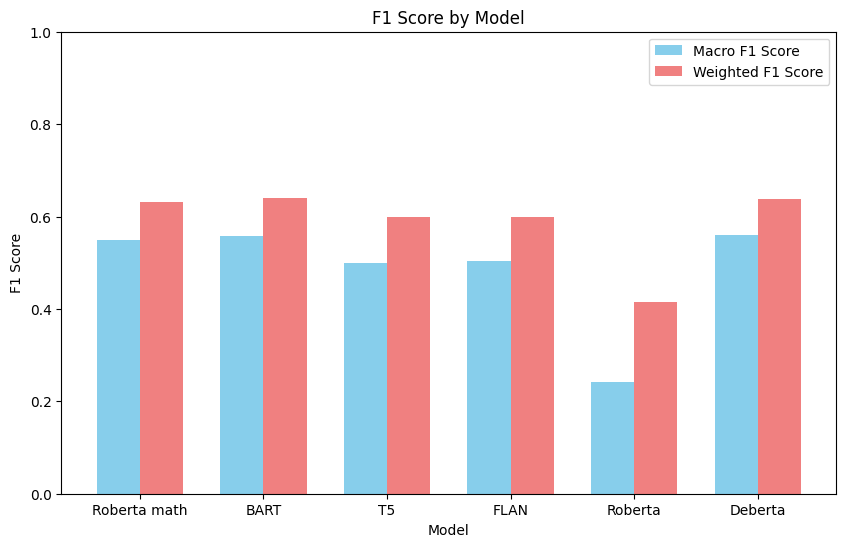

                                   model  f1_score_macro  f1_score_weighted
0          AnReu/math_pretrained_roberta        0.549710           0.630418
1               facebook/bart-large-mnli        0.557186           0.641010
2                     google-t5/t5-small        0.499431           0.599547
3                   google/flan-t5-small        0.504206           0.599624
4                     roberta-large-mnli        0.242130           0.414290
5  sileod/deberta-v3-base-tasksource-nli        0.560868           0.638622


In [3]:
############### Calculating F1 score 
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

pf = pd.read_csv('/kaggle/input/model-predictions/model_predictions_top_20.csv') 

# Calculate F1 scores for each model
f1_scores_macro = pf.groupby('model').apply(lambda x: f1_score(x['actual'], x['prediction'], average='macro')).reset_index()
f1_scores_macro.columns = ['model', 'f1_score_macro']

f1_scores_weighted = pf.groupby('model').apply(lambda x: f1_score(x['actual'], x['prediction'], average='weighted')).reset_index()
f1_scores_weighted.columns = ['model', 'f1_score_weighted']

# Merge the two F1 score DataFrames
f1_scores = pd.merge(f1_scores_macro, f1_scores_weighted, on='model')

# Plotting the F1 scores
fig, ax = plt.subplots(figsize=(10, 6))

# Define the bar width and positions
bar_width = 0.35
index = range(len(f1_scores))

# Plot macro F1 scores
bar1 = ax.bar([i - bar_width/2 for i in index], f1_scores['f1_score_macro'], bar_width, label='Macro F1 Score', color='skyblue')

# Plot weighted F1 scores
bar2 = ax.bar([i + bar_width/2 for i in index], f1_scores['f1_score_weighted'], bar_width, label='Weighted F1 Score', color='lightcoral')

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Model')
ax.set_ylim(0, 1)  # F1 score ranges from 0 to 1
ax.set_xticks(index)
ax.set_xticklabels(f1_scores['model'])
print(f1_scores['model'])
ax.set_xticklabels(['Roberta math' , 'BART' , 'T5' , 'FLAN' , 'Roberta' , 'Deberta']) # check if names match
ax.legend()
print(f1_scores)
# Show plot
plt.show()
print(f1_scores)

In [2]:
############### Calculating F1 score 
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd

pf = pd.read_csv('/kaggle/input/model-predictions/model_predictions_top_20.csv') 

# Calculate F1 scores for each model and taxonomy label
f1_scores = pf.groupby(['model', 'taxonomy']).apply(
    lambda x: f1_score(x['actual'], x['prediction'], average='weighted')
).reset_index()
f1_scores.columns = ['model', 'taxonomy', 'f1_score']

# Display the F1 scores DataFrame
print(f1_scores)

                                    model     taxonomy  f1_score
0           AnReu/math_pretrained_roberta   comparison  0.511021
1           AnReu/math_pretrained_roberta     interval  0.631766
2           AnReu/math_pretrained_roberta  statistical  0.581680
3           AnReu/math_pretrained_roberta     temporal  0.749564
4           AnReu/math_pretrained_roberta  temporal     0.333333
5                facebook/bart-large-mnli   comparison  0.525318
6                facebook/bart-large-mnli     interval  0.634344
7                facebook/bart-large-mnli  statistical  0.595528
8                facebook/bart-large-mnli     temporal  0.767299
9                facebook/bart-large-mnli  temporal     0.000000
10                     google-t5/t5-small   comparison  0.541573
11                     google-t5/t5-small     interval  0.589688
12                     google-t5/t5-small  statistical  0.550570
13                     google-t5/t5-small     temporal  0.693518
14                     go

/tmp/ipykernel_33/1487545768.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f1_scores = pf.groupby(['model', 'taxonomy']).apply(


In [11]:
# qualitative analysis

# Determine which models failed in their predictions (i.e., where prediction != actual)
df['failed'] = df['prediction'] != df['actual']

# Group by claim and taxonomy to check if all models except model1 failed
result = df.groupby(['claim index', 'taxonomy']).apply(
    lambda x: (x['model'] == 'AnReu/math_pretrained_roberta').any() and (x[x['model'] != 'AnReu/math_pretrained_roberta']['failed']).all()
).reset_index()
result.columns = ['claim index', 'taxonomy', 'all_others_failed']

# Filter for claims where all other models except model1 failed
failed_claims = result[result['all_others_failed']]

# Select only the necessary columns from the original dataframe
final_df = df[df['claim index'].isin(failed_claims['claim index']) & df['taxonomy'].isin(failed_claims['taxonomy'])]

# Keep only unique claim and taxonomy pairs
final_df = final_df[['claim index', 'taxonomy']].drop_duplicates().reset_index(drop=True)

print(final_df)



     claim index     taxonomy
0             12  statistical
1             14  statistical
2             21  statistical
3             26  statistical
4             30     interval
..           ...          ...
359         2419  statistical
360         2426  statistical
361         2476  statistical
362         2480   comparison
363         2481  statistical

[364 rows x 2 columns]


/tmp/ipykernel_33/4278121043.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['claim index', 'taxonomy']).apply(


In [40]:
# i = 0 
# for index, row in final_df.iterrows():
#     claim_index = row['claim index'] 
#     print(claim_index , "   ",   test_data[claim_index]['claim'] ,test_labels[claim_index] )
#     i+= 1 
# #     if i == 5: 
# #         break

# # print(test_data[14]['claim']) 
print(test_features_final[31])
print('-----------------')
print(test_features_final[54]) 

['i n s u m m a r y. landscape exposure to multiple stress- ors can pose risks to human health, biodiversity, and ecosystem services.6 pagine', "... facebook photos? 250 e mckinley st? 4701 n ashland ave chicago il 60640, don't ... jai shri ram ringtone download mp3, resident evil 5 game download for pc.", '16 gen 2020  from: h s truman political correctness is a doctrine, recently fostered by a delusional, illogical minority and promoted by a sick ...', 'daily. see covid-19 pandemic deaths for tables for all years, and for world maps and graphs. sorted by march. locations link to covid-19 pages. v t e', 's t a t e of a l a s k a. division of elections number of registered voters by party within precinct date: 09/03/2020  key to recognized political party / ...', "s texas school for health. 794. 5a. s tx science academy. 768. 5a. h energy ... 315. 4a. h energized for stem - west. 307. 4a. fw terrell. 303. 4a. sa young men's ...32 pages", 'senator sheila e harsdorf. caucus sergeant at a

In [34]:
df = pd.read_csv('/kaggle/input/model-predictions/model_predictions_top_20.csv') 
print(len(df)) 

indices = [] 
for i in range(6):
    indices = indices + [j for j in range(len(test_data))] 
    
df['claim index'] = indices 
df = df[df['taxonomy'] != 'temporal   ']
print(df['taxonomy'].unique())
print( df['taxonomy'].value_counts())
df.head()

14970
['statistical' 'temporal' 'comparison' 'interval']
taxonomy
statistical    7260
temporal       4086
interval       2082
comparison     1530
Name: count, dtype: int64


,model,prediction,actual,taxonomy,claim index
0,roberta-large-mnli,1,0,statistical,0
1,roberta-large-mnli,1,2,statistical,1
2,roberta-large-mnli,1,1,temporal,2
3,roberta-large-mnli,1,1,statistical,3
4,roberta-large-mnli,1,2,temporal,4


In [44]:
# conflicting: 0 , true: 2 , false: 1 
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

results = {}

for model in models:
    model_df = df[df['model'] == model]
    y_true = model_df['actual']
    y_pred = model_df['prediction']
    cm = confusion_matrix(y_pred, y_true)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    recall_0 = report['0']['recall']
    precision_0 = report['0']['precision']
    f1_0 = report['0']['f1-score']

    results[model] = {
        'confusion_matrix': cm,
        'recall_0': recall_0,
        'precision_0': precision_0,
        'f1_0': f1_0,
        'accuracy': accuracy
    }

for model, metrics in results.items():
    print(f'Model: {model}')
    print(f'Confusion Matrix:\n{metrics["confusion_matrix"]}')
    print(f'Recall for label 0: {metrics["recall_0"]:.2f}')
    print(f'Precision for label 0: {metrics["precision_0"]:.2f}')
    print(f'F1 Score for label 0: {metrics["f1_0"]:.2f}')
    print(f'Accuracy: {metrics["accuracy"]:.2f}\n')

Model: roberta-large-mnli
Confusion Matrix:
[[   0    0    0]
 [ 597 1423  473]
 [   0    0    0]]
Recall for label 0: 0.00
Precision for label 0: 0.00
F1 Score for label 0: 0.00
Accuracy: 0.57

Model: google-t5/t5-small
Confusion Matrix:
[[ 190  111  143]
 [ 285 1209  180]
 [ 122  103  150]]
Recall for label 0: 0.32
Precision for label 0: 0.43
F1 Score for label 0: 0.37
Accuracy: 0.62

Model: facebook/bart-large-mnli
Confusion Matrix:
[[ 203  117  108]
 [ 242 1198  135]
 [ 152  108  230]]
Recall for label 0: 0.34
Precision for label 0: 0.47
F1 Score for label 0: 0.40
Accuracy: 0.65

Model: sileod/deberta-v3-base-tasksource-nli
Confusion Matrix:
[[ 223  152  100]
 [ 195 1120  117]
 [ 179  151  256]]
Recall for label 0: 0.37
Precision for label 0: 0.47
F1 Score for label 0: 0.42
Accuracy: 0.64

Model: google/flan-t5-small
Confusion Matrix:
[[ 180  127  129]
 [ 253 1161  158]
 [ 164  135  186]]
Recall for label 0: 0.30
Precision for label 0: 0.41
F1 Score for label 0: 0.35
Accuracy: 0.61